In [1]:
IMAGES_LOCATION = "/home/kostrovy/data/x_ray/train"
TEST_IMAGES = "/home/kostrovy/data/x_ray/test"
IMG_HEIGHT= 224
IMG_WIDTH = 224
BATCH_SIZE = 16

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path


import imageio
import cv2
import skimage.transform

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, recall_score, accuracy_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def img_class(cl):
    if cl[0] == 1:
        return 0
    else:
        return 1 

In [7]:
def create_label(label):
    #print(label)
    return label
    if label == 'red':
        return 1
    else:
        return 0

In [8]:
plt.style.use('fivethirtyeight')
toy=False

In [9]:
files =[]
for r, d, f in os.walk(IMAGES_LOCATION):
    for file in f:
        files.append(os.path.join(r,file))

In [10]:
images = pd.DataFrame(files)
images.columns = ['path']
images['label'] = images.path.apply(lambda x:create_label(x.split('/')[-2]) )

In [11]:
images.shape

(5233, 2)

In [12]:
normal = images[images.label == 'NORMAL']

In [13]:
normal.head()

,path,label
1,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
2,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
3,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
4,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
5,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL


In [14]:
len(normal)

1349

In [15]:
pnemonia = images[images.label =='PNEUMONIA']
pnemonia.head()
len(pnemonia)

3883

In [16]:
print(len(normal),len(pnemonia))

1349 3883


In [17]:
df = pd.concat([normal,pnemonia])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,label
0,/home/kostrovy/data/x_ray/train/PNEUMONIA/BACT...,PNEUMONIA
1,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
2,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
3,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
4,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL


(600, 1064)


Text(0.5, 1.0, 'PNEUMONIA')

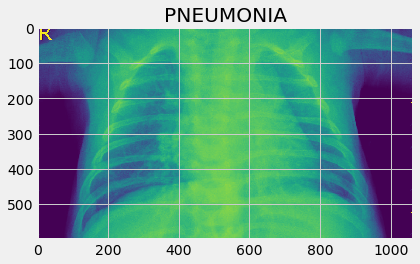

In [18]:
import matplotlib.image as mpimg
numb= np.random.randint(0,df.shape[0])
img = mpimg.imread(df.loc[numb]['path'])

print(img.shape)
plt.imshow(img)
plt.title(df.loc[numb]['label'])

In [19]:
df_train, df_test = train_test_split(df, random_state=42)
print(df_train.shape, df_test.shape)

(3924, 2) (1308, 2)


# CREATE TEST FILES FOR FINAL TESTING 

Text(0.5, 1.0, 'NORMAL')

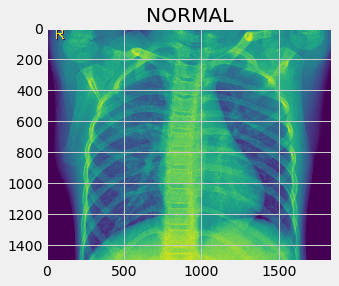

In [20]:
test_files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        test_files.append(os.path.join(r,file))
test_images = pd.DataFrame(test_files)
test_images.columns = ['path']
test_images['label'] = images.path.apply(lambda x:create_label(x.split('/')[-2]) )
test_images.drop(0, axis=0,inplace=True)
test_images.loc[1,'path']
img = mpimg.imread(test_images.loc[1,'path'])
plt.imshow(img)
plt.title(test_images.loc[1,'label'])

In [21]:
datagen_model_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [22]:
#test_img_generator=datagen_model_test.flow_from_dataframe(
test_img_generator=datagen_model_test.flow_from_directory(
    TEST_IMAGES, 
    batch_size=624,
    target_size=(IMG_HEIGHT,IMG_HEIGHT),
    seed=42)

Found 624 images belonging to 2 classes.


# Create Data generators for training 

In [23]:
datagen_train=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    #validation_split=0.25
    )
datagen_test = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [24]:
train_generator=datagen_train.flow_from_dataframe(
dataframe=df_train,
x_col="path",
y_col="label",
#subset="training",
batch_size=BATCH_SIZE,
seed=42,
#shuffle=True,
#target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 3924 validated image filenames belonging to 2 classes.


In [25]:
valid_generator=datagen_test.flow_from_dataframe(
dataframe=df_test,
x_col="path",
y_col="label",
#subset="validation",
batch_size=BATCH_SIZE,
seed=42,
#shuffle=True,
#class_mode="binary",
target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 1308 validated image filenames belonging to 2 classes.


In [26]:
CLASSES = 2
base_model = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
#base_model = VGG19(include_top=False, input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
#base_model = Xception(include_top=False,weights='imagenet', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3))
#base_model = Xception(include_top=False,weights='imagenet', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3))

In [27]:
for i,j in valid_generator:
    print(i.shape,j.shape)
    break

(16, 224, 224, 3) (16, 2)


In [28]:
#CLASSES = 2

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(units=512,activation="relu")(x)
#x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=predictions)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
#for layer in base_model.layers:
#    layer.trainable = True
base_model.trainable = False

In [31]:
metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()]
#opt = Adam(lr=0.000001)
#opt = SGD(lr=0.00001)
#model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.Adam(),
#                            loss=tf.keras.losses.BinaryCrossentropy(),
#                            metrics=['accuracy']
#                            )
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [32]:
EPOCHS = 10
STEPS_PER_EPOCH = 200
VALIDATION_STEPS = 32
MODEL_FILE = 'filename.model'

history = model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)

Epoch 1/10
200/200 [==============================] - 53s 248ms/step - loss: 1.5102 - recall: 0.6403 - accuracy: 0.0069 - val_loss: 0.3467 - val_recall: 0.8887 - val_accuracy: 9.7656e-04
Epoch 2/10
200/200 [==============================] - 48s 241ms/step - loss: 0.4413 - recall: 0.8333 - accuracy: 0.0070 - val_loss: 0.2340 - val_recall: 0.9180 - val_accuracy: 0.0020
Epoch 3/10
200/200 [==============================] - 48s 240ms/step - loss: 0.3463 - recall: 0.8800 - accuracy: 0.0162 - val_loss: 0.2087 - val_recall: 0.9395 - val_accuracy: 0.0049
Epoch 4/10
200/200 [==============================] - 48s 239ms/step - loss: 0.3103 - recall: 0.8792 - accuracy: 0.0159 - val_loss: 0.2204 - val_recall: 0.9199 - val_accuracy: 0.0039
Epoch 5/10
200/200 [==============================] - 48s 239ms/step - loss: 0.2990 - recall: 0.8933 - accuracy: 0.0235 - val_loss: 0.2563 - val_recall: 0.9043 - val_accuracy: 0.0078
Epoch 6/10
200/200 [==============================] - 48s 240ms/step - loss: 0.29

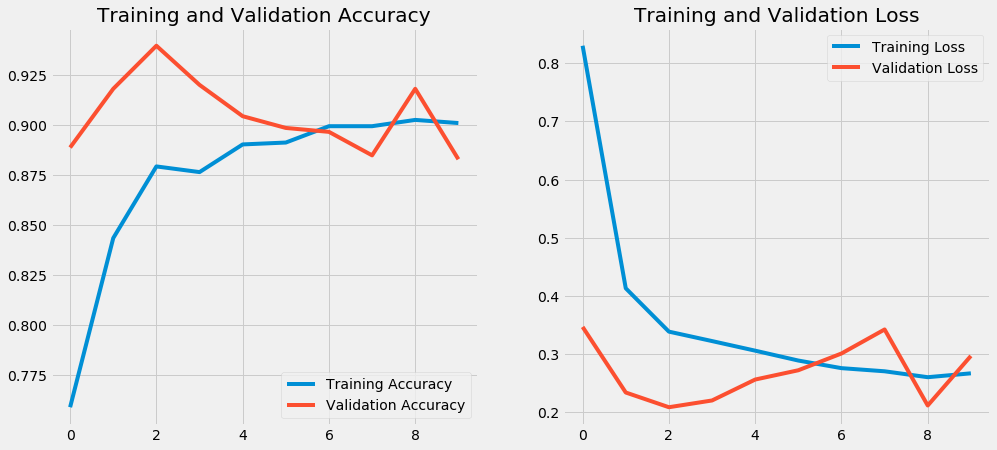

In [33]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
preds = None
true_y = None
for i,j in test_img_generator:
    print(len(i))
    print(len(np.round(model.predict(i))))
    preds = np.round(model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

624
624
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[[223  11]
 [ 36 354]]
0.9076923076923077
0.9246794871794872


In [39]:
base_model.trainable = True

In [40]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [41]:
EPOCHS = 20
history = model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)
#model.save(MODEL_FILE)

Epoch 1/20
200/200 [==============================] - 50s 244ms/step - loss: 0.1709 - recall: 0.9158 - accuracy: 0.0404 - val_loss: 0.2788 - val_recall: 0.8770 - val_accuracy: 0.0244
Epoch 2/20
200/200 [==============================] - 48s 241ms/step - loss: 0.1274 - recall: 0.9496 - accuracy: 0.1168 - val_loss: 0.1401 - val_recall: 0.9570 - val_accuracy: 0.1846
Epoch 3/20
200/200 [==============================] - 49s 243ms/step - loss: 0.0865 - recall: 0.9697 - accuracy: 0.1540 - val_loss: 0.1800 - val_recall: 0.9336 - val_accuracy: 0.2383
Epoch 4/20
200/200 [==============================] - 48s 241ms/step - loss: 0.0941 - recall: 0.9681 - accuracy: 0.1795 - val_loss: 0.2257 - val_recall: 0.9277 - val_accuracy: 0.2422
Epoch 5/20
200/200 [==============================] - 48s 241ms/step - loss: 0.0840 - recall: 0.9666 - accuracy: 0.1749 - val_loss: 0.2638 - val_recall: 0.9121 - val_accuracy: 0.2129
Epoch 6/20
200/200 [==============================] - 49s 243ms/step - loss: 0.0611 -

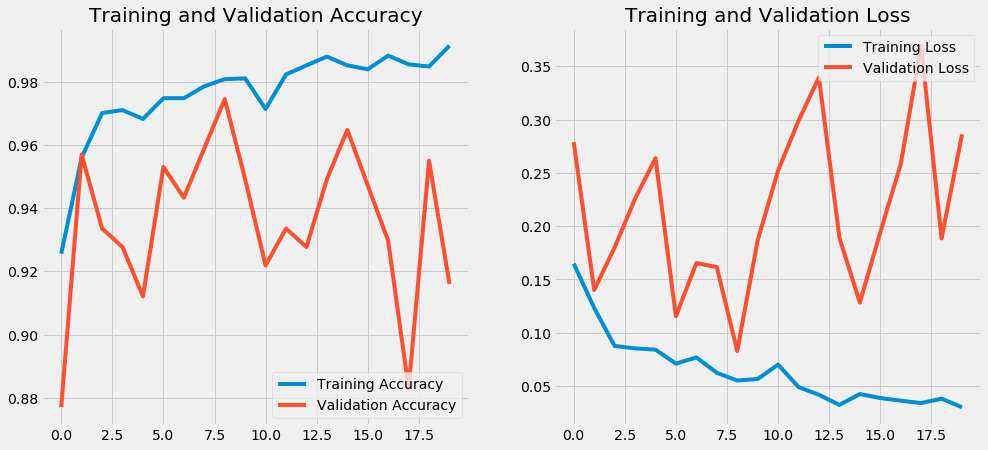

In [43]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
model

In [45]:
preds = None
true_y = None
for i,j in test_img_generator:
    print(len(i))
    print(len(np.round(model.predict(i))))
    preds = np.round(model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

624
624
[0, 1, 0, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
[[230   4]
 [ 25 365]]
0.9358974358974359
0.9535256410256411


In [68]:
#model.evaluate(test_img_generator, batch_size=16, verbose=2)

In [46]:
del model